In [0]:
!pip install soundfile
!pip install torchaudio
import torch, torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torchaudio.functional import lfilter
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.io import loadmat
from scipy.signal import butter
import soundfile as sf
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Define some functions

# This function applies a high-pass filter to the signal
def pre_filter(data, cutoff):
    b, a = butter(1, cutoff, 'highpass')
    b = torch.Tensor(b).to(device)
    a = torch.Tensor(a).to(device)
    filtered = lfilter(data, a, b)
    return filtered

# Calculates the error-to-signal ratio for the loss function
def esr_loss(output, target):
    co = 0.95
    tf = pre_filter(target, co)
    of = pre_filter(output, co)
    nom = torch.sum((tf - of)**2)
    denom = torch.sum(tf**2)
    esr = nom/denom
    return esr

# Calculates the DC component of the signal for the loss function
def dc_loss(output, target):
    N = output.size(0)
    nom = (torch.sum((target - output))/N)**2
    denom = torch.sum(target**2)/N
    dc = nom/denom
    return dc

def reshape_data(data, seg_size, mb_size):
    # input: data sequence [x, 1], segment size int, mini_bacth size int
    segments = int(data.shape[0]/seg_size)
    segments -= segments%mb_size
    end = segments*seg_size
    reshaped = data[:end, 0].reshape(segments, seg_size, 1).float()

    return reshaped

def get_data(path):
    train = sp.io.loadmat(path + 'trainingMesa550Disto_Gain5.mat')['train']
    test = sp.io.loadmat(path + 'testMesa550Disto_Gain5.mat')['test']

    input = torch.from_numpy(train[:,0]).reshape(-1,1).float()
    target = torch.from_numpy(train[:,1]).reshape(-1,1).float()
    test_input = torch.from_numpy(test[:,0]).reshape(-1,1).float()
    test_target = torch.from_numpy(test[:,1]).reshape(-1,1).float()

    return input, target, test_input, test_target


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, self.hidden_size, self.num_layers, dropout=0.5, batch_first=True)
        #self.lstm = nn.LSTM(input_size, self.hidden_size, self.num_layers, dropout=0.2)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        #print(x.shape)
        hn = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).float()).to(device)
        cn = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).float()).to(device)
        # hn = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size).float()).to(device)
        # cn = Variable(torch.zeros(self.num_layers, x.size(1), self.hidden_size).float()).to(device)
        out, (hn, cn) = self.lstm(x, (hn,cn))
        out = self.linear(out)
        return out

In [0]:
# some info about the sound dataset
sample_rate = 44100

# Check if CUDA enbaled GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

# build the model
hidden_size = 32
num_layers = 2
model = RNN(1, hidden_size, num_layers)
model.float()
model.to(device)
criterion = nn.MSELoss()

# load data
path = './drive/My Drive/data/'
seq_length = 4000
batchsize = 40 # each batch is roughly 100 ms
train_seq, train_target_seq, test_seq, test_target_seq = get_data(path)
input = reshape_data(train_seq, seq_length, batchsize)
target = reshape_data(train_target_seq, seq_length, batchsize)
test_input = reshape_data(test_seq, seq_length, batchsize)
test_target = reshape_data(test_target_seq, seq_length, batchsize)
print(f'All data in batches of {seq_length}:', input.shape)

train_ds = TensorDataset(input, target) # setup a training dataset
test_ds = TensorDataset(test_input, test_target) # create a test dataset

# use ADAM as optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Just check that CUDA works properly
print('cuda_model=', next(model.parameters()).is_cuda)
print('cuda_input=', input.is_cuda)


In [0]:
# setup some arrays to store info on training and validation error
train_error = []
valid_error = []

In [0]:
#begin to train
epochs = 1000
for epoch in range(epochs):
    # Create a data loader for each new epoch with shuffled data
    train_dl = DataLoader(train_ds, batch_size=batchsize, num_workers=2, shuffle=True)
    print(f'EPOCH {epoch}')

    model.train()
    for i, (xb, yb) in enumerate(train_dl):

        # xb = xb.reshape(seq_length, batchsize, 1)
        # yb = yb.reshape(seq_length, batchsize, 1)
        xb, yb = xb.to(device), yb.to(device)
        #print('xb', xb.shape)

        def closure():
            optimizer.zero_grad()
            pred = model(xb)
            #print('pred', pred.shape)
            #loss = criterion(pred[:,-1,0], yb[:,-1,0])
            loss = criterion(pred, yb)
            #loss = esr_loss(pred[:,-1,0], yb[:,-1,0]) + dc_loss(pred[:,-1,0], yb[:,-1,0])
            #loss = esr_loss(pred, yb) + dc_loss(pred, yb)
            train_error.append(loss.item())
            if i%10 == 0:
                print(f'training loss[{i}]:{loss.item()}')
            loss.backward()
            return loss
        optimizer.step(closure)


    model.eval()
    with torch.no_grad():
        if epoch%1 == 0:
          batch_start = np.random.randint(0, test_input.size(0)-batchsize)
          batch_end = batch_start + batchsize
          y_test_input, y_test_target = test_input[batch_start:batch_end], test_target[batch_start:batch_end]
          #y_test_input, y_test_target = y_test_input.reshape(seq_length, batchsize, 1), y_test_target.reshape(seq_length, batchsize, 1)
          y_test_input, y_test_target = y_test_input.to(device), y_test_target.to(device)
          pred = model(y_test_input)
          #loss = criterion(pred[:,-1,0], y_test_target[:,-1,0])
          loss = criterion(pred, y_test_target)
          #loss = esr_loss(pred, y_test_target) + dc_loss(pred, y_test_target)
          #loss = esr_loss(pred[:,-1,0], y_test_target[:,-1,0]) + dc_loss(pred[:,-1,0], y_test_target[:,-1,0])
          valid_error.append(loss.item())
          print('validation loss:', loss.item())

In [0]:
#output a prediction of the signal at the current training level
start = 0 #seconds
stop = 10 #seconds
sample = test_seq[start*sample_rate:stop*sample_rate].reshape(1,sample_rate*stop,1)
model.eval()
pred = model(sample.to(device))
y = pred.cpu().detach().numpy()
sf.write(path+f'out{len(valid_error)}_ESR.wav', y[0,:,0], sample_rate, 'PCM_24')

sample_target = test_target_seq[start*sample_rate:stop*sample_rate].reshape(1, sample_rate*stop,1)
#sf.write(path+f'target_Mesa550Disto_Gain5.wav', sample_target[0,:,0], sample_rate, 'PCM_24')

raw_input = test_seq[start*sample_rate:stop*sample_rate].reshape(1, sample_rate*stop,1)
#sf.write(path+f'raw_input.wav', raw_input[0,:,0], sample_rate, 'PCM_24')

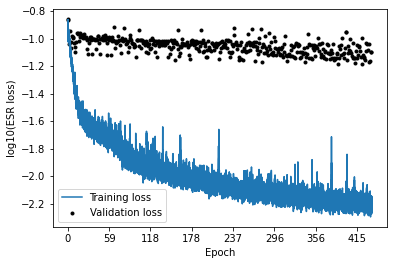

In [9]:
# Create som plots
fig, ax = plt.subplots(1,1)
stride = int(len(train_error)/len(valid_error))
tick = [-1]

ax.plot(np.log10(train_error), label='Training loss')
#ax.plot(train_error, label='Training loss')
for i in range(len(valid_error)):
  x = i*stride
  y = np.log10(valid_error[i])
  #y = valid_error[i]
  ax.scatter(x, y, marker='.', color='black')
ax.scatter(x, y, marker='.', color='black', label='Validation loss')

locs, _ = plt.xticks()
for i in range(1, len(locs)):
  loc = locs[i]
  tick.append(int(loc/len(train_error)*len(valid_error)))

ax.set_xticklabels(tick)
ax.set_xlabel('Epoch')
ax.set_ylabel(r'log10(ESR loss)')
#ax.set_ylabel(r'MSE loss')
plt.legend()
#plt.savefig(path+'loss_over_time_MSE.png', dpi=120)

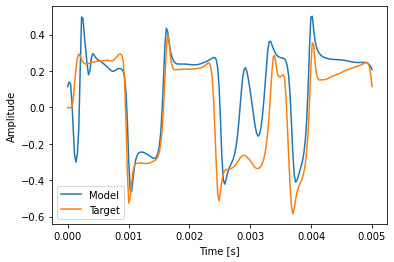

In [14]:
# Setup some time information to select from 
t_start = 0.00
t_stop = 0.005
start = int(t_start*sample_rate) #seconds
stop = int(t_stop*sample_rate) #seconds

# Get a prediction from the model
sample_input = test_seq[start:stop].reshape(1, stop-start,1).to(device)
model.eval()
pred = model(sample_input).cpu().detach().numpy()
y_model = pred[0,:,0]

# Get the target sequence
sample_target = test_target_seq[start:stop].reshape(1, stop-start,1)
y_target = sample_target.cpu().detach().numpy()[0,:,0]

t = np.linspace(t_start,t_stop, stop-start)
plt.plot(t, y_model, label='Model')
plt.plot(t, y_target, label='Target')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
#plt.savefig(path+'waveform_MSE.png', dpi=120)
